# Traveling Salesman Problem
Consider the following graph with four cities and the distances between them. Find the shortest
path that would enable the salesman to visit all the cities and return to its hometown. You can
choose your hometown among the four cities.
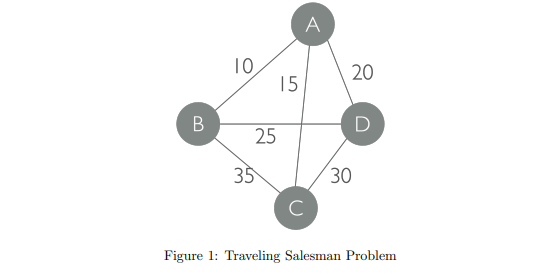
#### 1. ) Solve this problem in classical algorithms and report the result and your code whose filename should follow “ClassicalTSP” and file format can be chosen by you (e.g. .py, .ipynb, ...).\

### Choose A as hometown


## Brute force method:
This particular instance of the Traveling Salesman Problem (TSP) is small enough that we can solve it optimally using brute force, by trying all possible permutations of the cities and determining the shortest route.

In [1]:
from itertools import permutations
import time
import sys

# Start tracking time
start_time = time.time()

# Define the distances between the cities in a dictionary
# Each tuple represents a bidirectional edge with its associated distance
distances = {
    ('A', 'B'): 10,
    ('A', 'C'): 15,
    ('A', 'D'): 20,
    ('B', 'C'): 35,
    ('B', 'D'): 25,
    ('C', 'D'): 30
}

# Make the distance matrix symmetric by filling in the missing entries
# This is important for the TSP to ensure that the distance from city i to j is the same as from j to i
distances.update({(j, i): distances[(i, j)] for i, j in distances})

# Define the list of cities involved in the problem
cities = ['A', 'B', 'C', 'D']

# Choose a starting city for the TSP
start_city = 'A'
# Create a list of the other cities that excludes the starting city
other_cities = [c for c in cities if c != start_city]

# Function to calculate the total distance of a given path
# The path does not include the starting city; it will be added to the start and end of the path
def calculate_total_distance(path):
    total_distance = 0
    # Add the distance from the starting city to the first city in the path
    total_distance += distances[(start_city, path[0])]
    # Iterate over the path to sum the distances between consecutive cities
    for i in range(len(path) - 1):
        total_distance += distances[(path[i], path[i + 1])]
    # Add the distance from the last city back to the starting city to complete the circuit
    total_distance += distances[(path[-1], start_city)]
    return total_distance

# Initialize the shortest path and distance with None and infinity, respectively
shortest_path = None
shortest_distance = float('inf')

# Generate all permutations of the other cities and evaluate them
# This is the brute force part of the algorithm, testing every possible route
for perm in permutations(other_cities):
    # Calculate the distance for the current permutation
    current_distance = calculate_total_distance(perm)
    # If the current distance is shorter than the recorded shortest distance, update the shortest path and distance
    if current_distance < shortest_distance:
        shortest_distance = current_distance
        shortest_path = perm

# End tracking time
end_time = time.time()

# Calculate and print the memory usage of the distances dictionary
# sys.getsizeof returns the size in bytes; we convert it to kilobytes
memory_usage_kb = sys.getsizeof(distances) / 1024

# Print out the results with descriptive statements
print(f"The shortest path starting from city '{start_city}' is: {' -> '.join((start_city,) + shortest_path + (start_city,))}")
print(f"The total distance of the shortest path is: {shortest_distance} units.")
print(f"The algorithm took {end_time - start_time:.6f} seconds to find the shortest path.")
print(f"The memory usage for the distance matrix is: {memory_usage_kb:.3f} KB.")


The shortest path starting from city 'A' is: A -> B -> D -> C -> A
The total distance of the shortest path is: 80 units.
The algorithm took 0.000691 seconds to find the shortest path.
The memory usage for the distance matrix is: 0.625 KB.


## Dynamic Programming Approach Using Held-Karp Algorithm for TSP:

The Held-Karp algorithm is an efficient dynamic programming solution for the Traveling Salesman Problem (TSP), particularly suited for small to medium-sized problems. Seems like another good choice of algorithm to compare to the brute force method.

Key features of the Held-Karp algorithm:
- **Subproblem Optimization**: It breaks down the TSP into smaller subproblems, optimally solving each to build up to the final solution.
- **Cost Assignment**: Assigns a cost to each subset of cities, considering each city as a potential endpoint.
- **Iterative Computation**: Starts with subsets of size 2, incrementally increases subset size, calculating the minimum cost path for each.
- **Path Construction**: After evaluating all subsets, the shortest path is constructed by backtracking from the final city to the start.
- **Complexity**: The time complexity is O(n^2 * 2^n), which is more manageable than O(n!) but still limits its use to relatively small datasets.

The implementation below applies the Held-Karp algorithm to a TSP instance with four cities, demonstrating its approach in reducing computation time compared to brute force methods.


In [2]:
from itertools import permutations, combinations
import time
import sys

# Create the distance matrix from the distances dictionary
distance_matrix = [[distances.get((city1, city2), 0) if city1 != city2 else 0 for city2 in cities] for city1 in cities]

# Redefine the Held-Karp algorithm using the distance matrix
def held_karp_tsp(distance_matrix):
    n = len(distance_matrix)  # Number of cities
    C = {}  # Cost dictionary to store the best cost to reach each subset of cities ending at each city

    # Set initial costs for direct paths from the start city (city 0) to each other city
    for k in range(1, n):
        # Store the cost of going from city 0 to city k, with '0' indicating the start city
        C[(1 << k, k)] = (distance_matrix[0][k], 0)

    # Iteratively build up the solution for subsets of cities
    for subset_size in range(2, n):
        # Generate all combinations of cities for the current subset size
        for subset in combinations(range(1, n), subset_size):
            # Convert the subset of cities to a binary representation
            bits = 0
            # If a city is in the subset, its corresponding bit is set to 1. 
            # This is achieved using bitwise OR (|=) and left shift (<<). 
            for bit in subset:
                bits |= 1 << bit

            # Calculate the minimum cost to reach this subset for each end city in the subset
            for k in subset:
                prev = bits & ~(1 << k)  # Remove the current end city from the subset
                res = []

                # Calculate the cost for each possible preceding city in the subset
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    # Add the cost from the previous subset plus the distance to city k
                    res.append((C[(prev, m)][0] + distance_matrix[m][k], m))

                # Update the cost dictionary with the minimum cost to reach the subset ending at city k
                C[(bits, k)] = min(res)
    
    # Include the cost of returning to the start city (city 0) from each city
    bits = (2**n - 1) - 1  # Binary representation of all cities visited
    res = []

    # Calculate the cost for each city to return to the start city
    for k in range(1, n):
        res.append((C[(bits, k)][0] + distance_matrix[k][0], k))
    # Find the minimum cost and the city leading to this cost
    opt, parent = min(res)

    # Backtrack to find the full path taken
    path = []
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)  # Remove the current city from the subset
        _, parent = C[(bits, parent)]  # Update the parent city for the next step
        bits = new_bits
    path.append(0)  # Add the start city to complete the cycle

    # Calculate the memory usage of the cost dictionary
    memory_usage_bytes = sum(sys.getsizeof(v) for v in C.values()) + sys.getsizeof(C)
    return opt, list(reversed(path)), memory_usage_bytes

# Execute the Held-Karp algorithm
overall_start_time = time.time()  # Start the timer
optimal_cost, optimal_path_indices, memory_usage_bytes = held_karp_tsp(distance_matrix)
overall_end_time = time.time()    # End the timer

# Translate the optimal path indices back to city names
optimal_path_cities = [cities[index] for index in optimal_path_indices]

# Print out the results
memory_usage_kb = memory_usage_bytes / 1024  # Convert memory usage to kilobytes
print(f"The shortest path starting from city '{start_city}' is: {' -> '.join((start_city,) + shortest_path + (start_city,))}")
print(f"The total distance of the shortest path is: {optimal_cost} units.")
print(f"The algorithm took {overall_end_time - overall_start_time:.6f} seconds to find the shortest path.")
print(f"The memory usage for the cost dictionary is: {memory_usage_kb:.3f} KB.")

The shortest path starting from city 'A' is: A -> B -> D -> C -> A
The total distance of the shortest path is: 80 units.
The algorithm took 0.000217 seconds to find the shortest path.
The memory usage for the cost dictionary is: 1.281 KB.


The brute force method took 0.000597 seconds to complete using about 0.625 KB while the dynamic algorithm took 0.000210 seconds while using 1.281 KB of memory. 

In algorithm design, the best solution depends on real-world needs, considering factors like runtime efficiency and memory usage. Also, choices must be made between code simplicity and readability versus its flexibility and adaptability.

As expected, the brute force method had a longer runtime but used less memory. On the other hand, the dynamic programming approach used more memory but was faster. This highlights the need to carefully consider the specific needs and limitations of each problem when choosing an algorithm.

## References

1. **GeeksforGeeks - Travelling Salesman Problem using Dynamic Programming**  
   [Travelling Salesman Problem using Dynamic Programming](https://www.geeksforgeeks.org/travelling-salesman-problem-using-dynamic-programming/)

2. **Medium by Tonic Canada - Introduction to the Travelling Salesman Problem**  
   [Introduction to the Travelling Salesman Problem](https://tonicanada.medium.com/introduction-to-the-travelling-salesman-problem-5ace44932cb5)

3. **Stack Overflow - Explanation of Held-Karp TSP Pseudocode**  
   [Can you help explain this Held-Karp TSP pseudocode](https://stackoverflow.com/questions/69902373/can-you-help-explain-this-held-karp-tsp-pseudocode)

4. **Medium by Data Overload - Unveiling the Held-Karp Algorithm**  
   [Unveiling the Held-Karp Algorithm: Revolutionizing the Traveling Salesman Problem](https://medium.com/@data-overload/unveiling-the-held-karp-algorithm-revolutionizing-the-traveling-salesman-problem-9fb45b4cf58d)

5. **GitHub - Mikymaione's Implementation of the Held-Karp Algorithm**  
   [Held-Karp Algorithm on GitHub](https://github.com/mikymaione/Held-Karp-algorithm)